# Graded Exercise Session: Circular Hough Transform

* At the end of the session please submit your code to Moodle.

The circular Hough Transform can be used to detect circles in edge images. It is very
similar to the linear Hough Transform, with the difference that there is one parameter
more to take into account: circle radius.
<p></p>
Assume we are given a pair of an original gray-scale image ```I[y, x]``` and a corresponding
edge image ```edge_I[y, x]```, of size $H \times W$, such that $0 ≤ y < H$ and $0 ≤ x < W$. Every
pixel of the edge image has logical value equal to 255 if the corresponding pixel of
the original image belongs to an edge, and 0 otherwise.
<p></p>
In this exercise you are asked to implement a version of Hough transform for detecting
circles. A circle can be represented in the following way:
<p></p>
\begin{equation*}
(x − x_c)^2 + (y − y_c)^2 = r^2, \hspace{0.5cm} 0 ≤ x_c < W, \hspace{0.5cm} 0 ≤ y_c < H, \hspace{0.5cm} \hspace{0.5cm} (1.1)
\end{equation*}
<p></p>
where $(y, x)$ are pixel coordinates in the edge image ```edge_I```, and $(y_c, x_c, r)$ are the
parameters of the model corresponding to the y- and x- coordinates of the center of the circle and its radius respectively.
<p></p>
If the radius of the circle to be found is fixed, then the parameter space is reduced to
2-d. Each point $(y, x)$ on the original circle (in the image space) defines a circle centered
at $(y, x)$ with radius $r$. The intersection point of all such circles in the
parameter space corresponds to the center point $(y_c, x_c)$ of the original circle on the
image space. An example is shown below.

<img src="images/hough.png">
Figure 1. In order to find the center of the blue circle, green circles centered at four edge points vote for the blue circle center $(y_c, x_c)$.
<p></p>
An accumulator matrix is used to find the intersection point in the parameter space. For a fixed radius, the accumulator array is a 2-D matrix, whose
    rows and columns correspond to different values of parameters of $y_c$ and $x_c$ respectively. This matrix is filled by passing through every edge point, formulating a circle centered at that point in
the parameter space and increasing the voting number of all the cells/pixels through which the new
circle passes. The number of “votes” in each element in the accumulator matrix denotes the number of circles in 
the parameter space that pass through the corresponding cell. 
<p></p>
After voting, we compute local maxima of the accumulator array. The positions of these
maxima correspond to the circle centers $(y_c, x_c)$ in the original image space.


In [307]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import math
from skimage.feature import peak_local_max
import cv2

### Q1. Creating Accumulator Array

* Implement a function ```accum = CircleHough(edge_I,r)``` as described below.

#### Inputs

- ```edge_I```: - edge image of size $H \times W $ with values 255 for edge pixels and 0 for non-edge pixels
- ```r```: - radius of the circle we want to detect

#### Outputs
- ```accum```: 2-d accumulator array of size $H \times W $ storing votes for every possible circle centre in the image

#### Proposed Steps.
<b>Note:</b> the proposed steps are only suggestion and you can implement the following functions however you wish to.

* Initialize the accumulator array with zeros.
* Find the set of coordinates $\{(y_e, x_e)\}$ of edge points in ```edge_I``` (tip: you can use function ```np.where(edge_I)``` )
* Implement a loop that does the following:
    * $\forall x \in \{x_e\}$ compute left and right boundaries $(x_l, x_r)$ of the circle to be investigated centered at $x$ and with radius $r$
    * $\forall x_c \in [ x_l,x_r ]$ compute $y_{c1}, y_{c2}$ using Eq. 1.1
    * increment ```accum``` at positions $(y_{c1},x_c)$ and $(y_{c2},x_c)$ if they are within image boundaries and ignore them otherwise

    

In [308]:
def CircleHough(edge_I,r):
    accum = np.zeros(edge_I.shape)
    im_w,im_h = edge_I.shape
    point_set = np.where(edge_I)
    for i in range(len(point_set[0])):
        x = point_set[0][i]
        x_l = x-r
        x_r = x+r
        for j in range(x_l,x_r+1):
            y_u =point_set[1][i] - math.sqrt(r**2 - (x-j)**2)
            y_d =point_set[1][i] + math.sqrt(r**2 - (x-j)**2)
            if 0<j< im_w and 0<y_u < im_h: 
                    accum[j,int(y_u)] +=1

            if 0<j< im_w and 0<y_d < im_h:
                    accum[j,int(y_u)] +=1
        
    # Implement your function here
    
    return accum    

* Below you can find the code to read the image and compute edges, you do not have to change it. Use ```edges``` image in the following exercises.

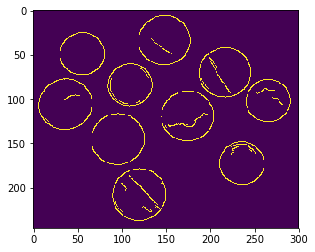

In [309]:
img = cv2.imread('images/coins.png',0)
edges = cv2.Canny(img,200,400)
plt.imshow(edges)
plt.show()


* Compute and visualize accumulator arrays for the given ```edges``` image and $r_1 = 25$ and $r_2 = 30$. What is the visual difference between them and what is the reason for that? Write your answer as a comment.

In [310]:
#Visualize two accumulator arrays here and write a comment
accum1 = CircleHough(edges,25)
accum2 = CircleHough(edges,50)

In [311]:
fig,ax = plt.subplots(1,2,figsize = (10,10))
ax[0].imshow(accum1)
ax[1].imshow(accum2)

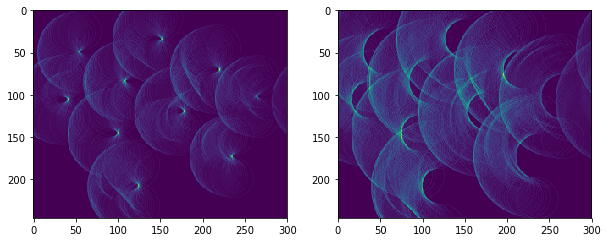

In [312]:
plt.show()

# answer
we can see that r1 are more reguler the intersect points is near the number of coin and has a good result and r2 is random you can find more intersect point which is not good. the reason is that in our picture,most of the circle's radius are around 25, so a near r is better

### Q2. Detect Circles
Implement ```y_c, x_c = DetectCircles(edge_I,radii,thres)``` function as described below and compute the coordinates of the coin centers.

#### Input parameters
- ```edge_I```: The edge image computed using the Canny Edge Detector (already computed in the above section)
- ```radii```: List of radius values that you want to detect in the image. eg: radii = [21,23,25] 
- ```thres```: Threshold used for thresholding the local maxima in accumulator array. It's the minimum intensity of the peaks. 

#### Output
- The outputs are the two dictionaries ```y_c``` and ```x_c``` storing y- and x-coordinates of detected circles' centers. See final step for more details. <b>Note</b> Instead of two dictionaries you can output also two arrays or two lists with corresponding radius.

#### Proposed Steps
Implement a loop such that for each radius value ```r``` in the radius range ```radii```, it does the following:
- Compute accumulator array for the edge image ```edge_I``` at radius ```r``` using function ```CircleHough```
- Find the local maxima that has peaks in the current accumulator array greater than the given threshold. You can use the function ```peak_local_max``` for this task. ***Hint***: you can use ```min_distance=20``` in the ```peak_local_max``` function.
- Store the x,y coordinates of the computed local maxima in x_c, y_c and return them as output from the function. ***Hint***:  Sample code to use dictionaries for x_c and y_c ,
    * ```x_c = dict() #Initialize dictionary x_c``` 
    * ```x_c[r] = x_coordinates_of_centers_you_computed_at_radius_r # we are assigning a list of x-coordinates to x_c[r] ``` 

In [313]:
peak_local_max(accum,min_distance =20,threshold_abs = 10)

array([[173, 235],
       [ 85, 109],
       [ 83, 108],
       [ 82, 109],
       [ 70, 220],
       [ 50,  55],
       [ 34, 152]])

In [332]:
def DetectCircles(edges,radii,thres):
    y_c = dict()
    x_c = dict()
    for i in radii :
        accum = CircleHough(edges,i)
        tt = peak_local_max(accum,min_distance =20,threshold_abs = thres)
        x_c[i] = []
        y_c[i] = []
        for j in tt :
            x_c[i].append(j[0])
            y_c[i].append(j[1])
        
    #Implement your function here
    return y_c,x_c

radii = range(20,30);
thres = 68
y_c, x_c = DetectCircles(edges, radii,thres)

In [333]:
y_c

{20: [],
 21: [],
 22: [238, 58],
 23: [237, 57],
 24: [109, 56],
 25: [100, 178, 41, 220],
 26: [123, 99, 177, 40, 219],
 27: [122, 98, 176, 39, 218, 149],
 28: [121, 97, 175, 38, 217, 148],
 29: [120, 96, 174, 37, 36, 216, 216, 147]}

### Q3. Visualization
To evaluate the approach we want to visualize the results. To this end implement a function ```ShowCircles(I,radii,x_c,y_c)``` as described below.
#### Inputs
- ```I```: original image
- ```radii```: a list of radii range
- ```x_c y_c ```: detected centers of circles

#### Proposed Steps
Implement a loop such that for each radius value ```r``` in the radius range ```radii``` does the following:
- Fetch the array of center points corresponding to the radius value ```r``` (e.g. ```x_c[r] and y_c[r]``` if you're using a dictionary).
- For each center point (cy, cx) in that array draw a circle with the corresponding radius ```r```
- Option 1: The set of points on the circle can be written as (cy+r∗sin(θ), cx+r∗cos(θ)). To reconstruct a circle iterate over theta values in range ```np.arange(0, 2*math.pi+1, 0.01)``` and for each point on the circle and the center point set the corresposing pixel value to white (255) to illustrate the circle. Functions ```math.sin()``` and ```math.cos()``` can be also useful.
- Option 2: If you are familiar with ```matplotlib```, you can create a figure using ```fig, ax = plt.subplots()``` and then you can define a circle using ```plt.Circle```. Finally you can add this circle to your figure using ```ax.add_patch()```. 

In [334]:
plt.Circle((2,4),5)
plt.show()

In [343]:
def ShowCircles(I,radii,x_c,y_c):
    for i in radii:
        for j in range(len(x_c[i])):
            x = x_c[i][j]
            y = y_c[i][j]
            for t in np.arange(0, 2*math.pi+1, 0.01):
                I[int(x+i*np.cos(t)),int(y+i*np.sin(t))] = 255
    return plt.imshow(I,'gray')
            
    #Implement your function here

* Now apply your implementation to the image in Figure 1 (left). In Figure 1 (right) we show a
representative result of applying the circular Hough transform. The figure on the right is obtained by using ```matplotlib``` functions in Option 2. The illustration of the circles might change depending on your visualization code. <b>Note</b> If you did not manage to complete the previous exercises uncomment the two first lines in the next cell. They will load precomputed centers, so that you can check your answer.

<figure>
  <img src="images/coins.png" width="278" height="270" style="float: left;margin: 10px 90px 0px 90px; " />
    <img src="images/coins_result.png" width="328" height="328" style="float: center; margin: -20px 0px 0px 0px; "/>
   
    <figcaption style="float: center; margin: 0px 0px 5px 200px;">Figure 1: Original image (left). Result of applying the circular Hough transform (right).</figcaption>
</figure>

In [344]:
#Uncomment those lines if you did not manage to complete the previous exercises, otherwise use the values you computed
#x_c  = np.load('x_center.npy').item()
#y_c = np.load('y_center.npy').item()
img = cv2.imread('images/coins.png',0)
edges = cv2.Canny(img,200,400)
ShowCircles(img,radii,x_c,y_c)

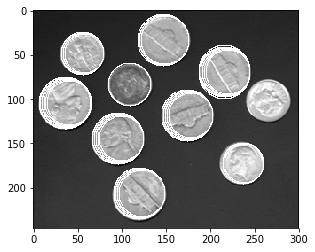

In [345]:
plt.show()